In [1]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
simulation_1 = './Au6_lvl4_cfea_scbase/output/'
simulation_2 = './Au6_lvl4_cfea_compressive/output/'

sims = [simulation_1, simulation_2]

In [3]:
def get_redshift(s, lookbacktime):
    a_test = np.linspace(1e-2,1,500)
    a_analogous = []
    for t in lookbacktime:
        a_analogous.append(a_test[np.absolute(s.cosmology_get_lookback_time_from_a(a_test, is_flat=True) - t).argmin()])
    a_analogous = np.array(a_analogous)
    return 1/a_analogous - 1

def calculate_cfr_and_age_distribution(sim, snapshot=127, nbins=100, min_range=0., max_range=13.):
    sf = load_subfind(snapshot, dir=sim, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=sim, subfind=sf, hdf5=True, loadonlyhalo=0, loadonlytype=[4])
    s.calc_sf_indizes( sf )
    galrad = 0.75 * sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    starparts = (s.data['age']>0.) * (s.r()<galrad)

    Lz = pylab.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    orbital_energy = s.data['pot'] + 0.5 * np.sum(s.data['vel']**2, axis=1)

    mask_clusters_initial = (s.data['incl'][starparts] > 0 )
    
    jz = Lz[starparts]
    ii = np.argsort(orbital_energy[starparts])
    eps = jz[ii]
    npm = 50
    eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
    ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
    ilist = ilist[ii] # ilist=5,4,3,2,1
    resort = np.argsort(ilist) # resort=5,4,3,2,1
    eps = eps[resort] # eps2=5,4,3,2,1


    # Build feature array: [ε, Energy]
    X = np.vstack((eps,orbital_energy[s.data['type']==4][starparts],
                    np.log10(np.abs(s.data['pos'][:,0][s.data['type']==4][starparts])))).T

    # Fit GMM
    gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[s.data['type']==4][starparts]), -1.5],
                                                        [0.9,np.median(orbital_energy[s.data['type']==4][starparts]), -2.5]],
                                                        covariance_type='full', random_state=42)
    gmm.fit(X)

    # Predict cluster memberships
    decomp_labels = gmm.predict(X)
    median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
    sph_label = np.argmin(median_eps)
    disc_label = np.argmax(median_eps)

    #Force assign disc_label to clusters with high circularity
    mask = (decomp_labels == sph_label) & (eps > 0.7)
    decomp_labels[mask] = disc_label

    plt.hist(eps, bins=20, range=[-2, 2],histtype='step')
    plt.hist(eps[decomp_labels==sph_label], bins=20, range=[-2, 2], histtype='step', label='Spheroid')
    plt.hist(eps[decomp_labels!=sph_label], bins=20, range=[-2, 2], histtype='step', label='Disc')
    plt.legend()
    plt.xlabel('Circularity ε')
    plt.show()
    
    decomposition = np.repeat(decomp_labels[mask_clusters_initial], s.data['incl'][starparts][mask_clusters_initial])

    mask_gc = (decomposition == sph_label)
    cluster_masses = s.data['mclt'][starparts][mask_clusters_initial].flatten()
    init_cluster_masses = s.data['imcl'][starparts][mask_clusters_initial].flatten()
    
    not_empty_clusters = (init_cluster_masses>0.)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    clusters_formtime = np.repeat(s.data['age'][starparts][mask_clusters_initial], s.data['incl'][starparts][mask_clusters_initial])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

    sfr, _ = np.histogram(s.cosmology_get_lookback_time_from_a(s.data['age'][starparts], is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True),\
                            bins=nbins, range=[min_range, max_range], weights=1e10*s.data['gima'][starparts] / ((max_range - min_range) / nbins) / 1e9)
    cfr_all, _ = np.histogram(clusters_age, bins=nbins, range=[min_range,max_range], weights=1e10*init_cluster_masses/((max_range-min_range)/nbins) /1e9)
    cfr_gc, bins = np.histogram(clusters_age[mask_gc * (1e10*init_cluster_masses > 1e5)], bins=nbins, range=[min_range,max_range],
                             weights=1e10*init_cluster_masses[mask_gc * (1e10*init_cluster_masses > 1e5)]/((max_range-min_range)/nbins) /1e9)
    # age_all, _ = np.histogram(clusters_age[(cluster_masses>0.)], bins=nbins, range=[min_range, max_range], density=True)
    # age_gc, bins = np.histogram(clusters_age[mask_gc * (cluster_masses>0.) * (1e10*init_cluster_masses > 1e5)], bins=nbins, range=[min_range, max_range], density=True)
    
    age_all = np.array([sp.stats.norm.pdf(np.linspace(0,14,100), loc=age, scale=0.5) for age in clusters_age]).sum(axis=0)
    age_gc = np.array([sp.stats.norm.pdf(np.linspace(0,14,100), loc=age, scale=0.5) for age in clusters_age[mask_gc * (1e10*init_cluster_masses > 1e5)]]).sum(axis=0)

    redshift_bins = get_redshift(s, bins)
    return sfr, cfr_all, cfr_gc, age_all, age_gc, bins, redshift_bins

In [4]:
nbins = 40
min_range = 0
max_range = 14

galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


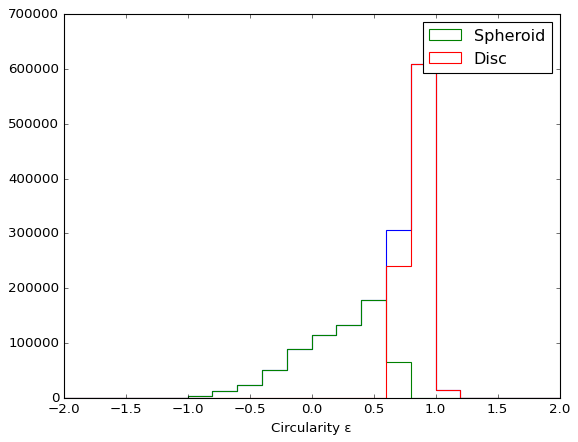

galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


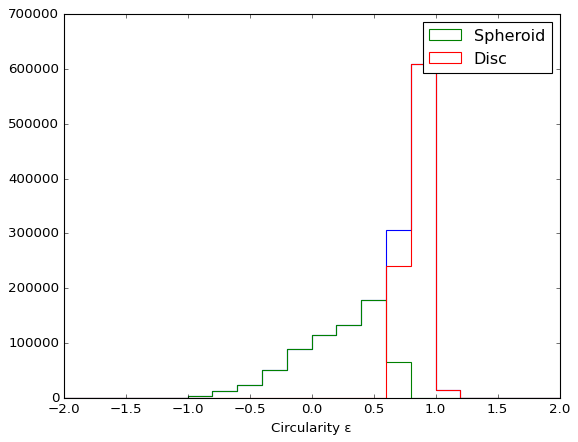

In [5]:
cluster_formation_rate_all = []
cluster_formation_rate_gc = []
age_distribution_surviving_all = []
age_distribution_surviving_gc = []

snapshot = 127
for sim in sims:
    sfr, cfr_all, cfr_gc, age_all, age_gc, bins, redshift_bins = calculate_cfr_and_age_distribution(sim, snapshot=snapshot, nbins=nbins, min_range=min_range, max_range=max_range)
    cluster_formation_rate_all.append(cfr_all)
    cluster_formation_rate_gc.append(cfr_gc)
    age_distribution_surviving_all.append(age_all)
    age_distribution_surviving_gc.append(age_gc)

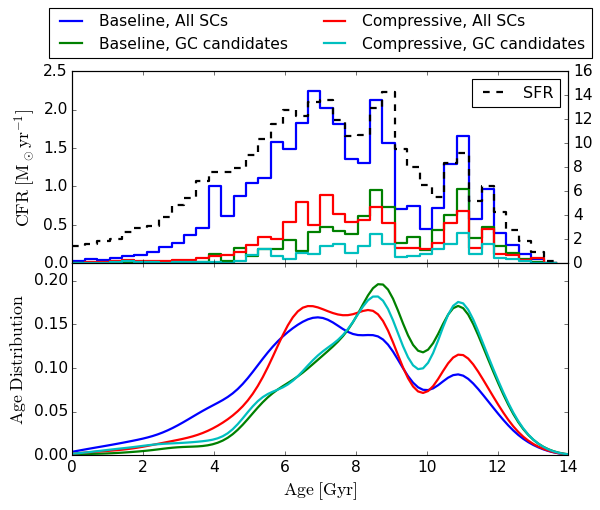

In [16]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].step(bins[:-1], cluster_formation_rate_all[0], where='post', linewidth=2, label='Baseline, All SCs')
ax[0].step(bins[:-1], cluster_formation_rate_gc[0], where='post', linewidth=2, label='Baseline, GC candidates')
ax[0].step(bins[:-1], cluster_formation_rate_all[1], where='post', linewidth=2, label='Compressive, All SCs')
ax[0].step(bins[:-1], cluster_formation_rate_gc[1], where='post', linewidth=2, label='Compressive, GC candidates')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
# ax[0].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[0].set_ylim(0,2.5)
ax[0].tick_params(axis='both', which='major', labelsize=14)
axr = ax[0].twinx()
axr.step(bins[:-1], sfr, where='post', color='black', linestyle='--', linewidth=2, label='SFR')
axr.legend()
axr.tick_params(axis='both', which='major', labelsize=14)

ax[1].plot(np.linspace(0,14,100), age_distribution_surviving_all[0]/np.trapezoid(age_distribution_surviving_all[0], np.linspace(0,14,100)), linewidth=2, label='Baseline, All SCs')
ax[1].plot(np.linspace(0,14,100), age_distribution_surviving_gc[0]/np.trapezoid(age_distribution_surviving_gc[0], np.linspace(0,14,100)), linewidth=2, label='Baseline, GC candidates')
ax[1].plot(np.linspace(0,14,100), age_distribution_surviving_all[1]/np.trapezoid(age_distribution_surviving_all[1], np.linspace(0,14,100)), linewidth=2, label='Compressive, All SCs')
ax[1].plot(np.linspace(0,14,100), age_distribution_surviving_gc[1]/np.trapezoid(age_distribution_surviving_gc[1], np.linspace(0,14,100)), linewidth=2, label='Compressive, GC candidates')
ax[1].set_ylim(0,0.22)
ax[1].set_ylabel(r'$\rm{Age \; Distribution}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].legend(loc='center', fontsize=14, bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.subplots_adjust(hspace=0.0)
plt.savefig('plots/age_distribution_and_cfr_paper.pdf', bbox_inches='tight')

galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


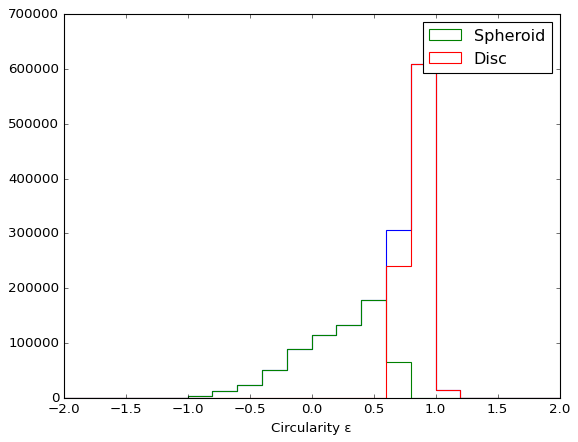

In [34]:
sfr, cfr_all, cfr_gc, age_all, age_gc, bins, redshift_bins = calculate_cfr_and_age_distribution('./Au6_lvl4_cfea_fiducial/output/', snapshot=127, nbins=nbins, min_range=min_range, max_range=max_range)

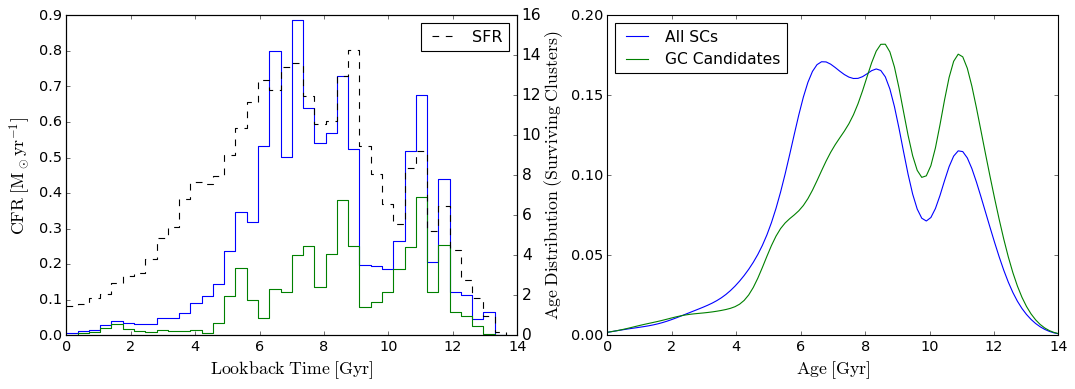

In [38]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

ax[0].step(bins[:-1], cfr_all, where='post', label='All SCs')
ax[0].step(bins[:-1], cfr_gc, where='post', label='GC Candidates')
ax[0].set_ylabel(r'$\rm{CFR \; [M_\odot yr^{-1}]}$', fontsize=16)
ax[0].set_xlabel(r'$\rm{Lookback \; Time \; [Gyr]}$', fontsize=16)
# ax[0].set_yscale('log')
ax[0].tick_params(axis='both', which='major', labelsize=13)
axr = ax[0].twinx()
axr.step(bins[:-1], sfr, where='post', color='black', linestyle='--', label='SFR')
axr.legend()
axr.tick_params(axis='both', which='major', labelsize=14)

ax[1].plot(np.linspace(0,14,100), age_all/np.trapezoid(age_all, np.linspace(0,14,100)), label='All SCs')
ax[1].plot(np.linspace(0,14,100), age_gc/np.trapezoid(age_gc, np.linspace(0,14,100)), label='GC Candidates')
ax[1].set_ylabel(r'$\rm{Age \; Distribution \; (Surviving \;Clusters)}$', fontsize=16)
ax[1].set_xlabel(r'$\rm{Age \; [Gyr]}$', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)
# ax[1].set_yscale('log')
ax[1].legend(fontsize=14, loc='upper left')